# Forcasting Energy Demand

# Setup

## Libraries

In [1]:
from adlfs import AzureBlobFileSystem
import duckdb
import pyarrow.dataset as ds
import os
import pandas as pd
import pendulum
import numpy as np
from statsmodels.tsa.stattools import adfuller

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from window_ops.rolling import rolling_mean
from utilsforecast.plotting import plot_series
from mlforecast import MLForecast

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pyarrow.parquet as pq
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from mlforecast.utils import PredictionIntervals

# set plotly as the default plotter
pd.options.plotting.backend = "plotly"

# number of columns to display
pd.options.display.max_columns = 100

In [2]:
from load_dotenv import load_dotenv

load_dotenv()

True

In [8]:

levels = [int(p) for p in os.environ['LEVELS'].split(', ')]
for p in levels:
    print(p)

10, 20, 30, 40, 50, 60, 70, 80, 90, 100
10
20
30
40
50
60
70
80
90
100


## Variables

In [30]:
ACC_KEY = os.environ["ACC_KEY"]
ACC_NAME = os.environ["ACC_NAME"]
CONTAINER_NAME = os.environ["CONTEINER"]
FOLDER = os.environ["FOLDER"]
FILE_NAME = os.getenv("AZURE_FILE_NAME")

# Data loading

In [32]:
abfs = AzureBlobFileSystem(
    account_name = ACC_NAME,
    account_key = ACC_KEY,
    container_name = CONTAINER_NAME
    )

path = f"abfs://{CONTAINER_NAME}/{FOLDER}/gold/aggregated_data_20240815.parquet"

pqdata = ds.dataset(path, filesystem=abfs)
pqdata.schema

date: date32[day]
daily_carga_mw: double

## Preprocesing

In [59]:
rename_dict = {
    "date": "ds",
    "daily_carga_mw": "y",
}

data = (
    pqdata
    .to_table()
    .to_pandas()
    .assign(
        date=lambda x: pd.to_datetime(x["date"]),
    )
    .rename(columns=rename_dict)
)

data

,ds,y
0,2021-01-01,517292.1985
1,2021-01-02,663260.0435
2,2021-01-03,656525.3775
3,2021-01-04,796937.2295
4,2021-01-05,875973.0590
...,...,...
1317,2024-08-10,795148.5160
1318,2024-08-11,698073.5950
1319,2024-08-12,805498.2440
1320,2024-08-13,844564.0770


# Exploratory Data Analysis

## Stationarity

In [60]:
def augmented_dickey_fuller_test(series , column_name):
    print (f'Dickey-Fuller test results for columns: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of observations used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("The data is stationary")
    else:
        print("Conclusion:====>")
        print("The null hypothesis cannot be rejected")
        print("The data is not stationary")

augmented_dickey_fuller_test(data["y"],'Ads')

Dickey-Fuller test results for columns: Ads
Test Statistic                   -3.193274
p-value                           0.020377
No Lags Used                     23.000000
Number of observations used    1298.000000
Critical Value (1%)              -3.435398
Critical Value (5%)              -2.863769
Critical Value (10%)             -2.567957
dtype: float64
Conclusion:====>
Reject the null hypothesis
The data is stationary


## Autocorrelation

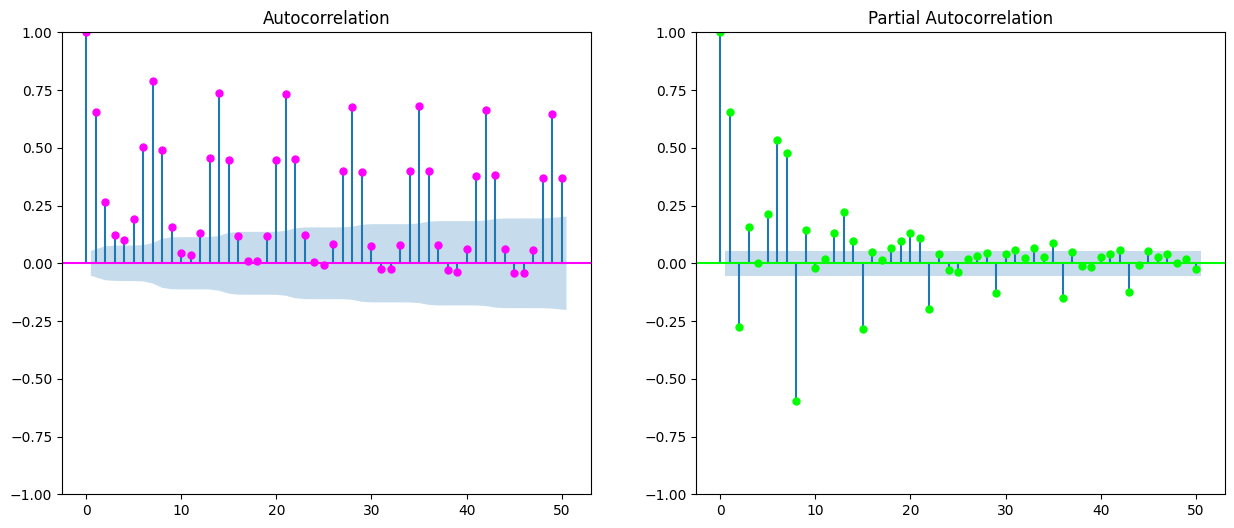

In [61]:
fig, axs = plt.subplots(figsize=(15,6), nrows=1, ncols=2)
n = 50

plot_acf(data["y"],  lags=n, ax=axs[0],color="fuchsia")
axs[0].set_title("Autocorrelation");

# Grafico
plot_pacf(data["y"],  lags=n, ax=axs[1],color="lime")
axs[1].set_title('Partial Autocorrelation')

plt.show()

## Decomposition

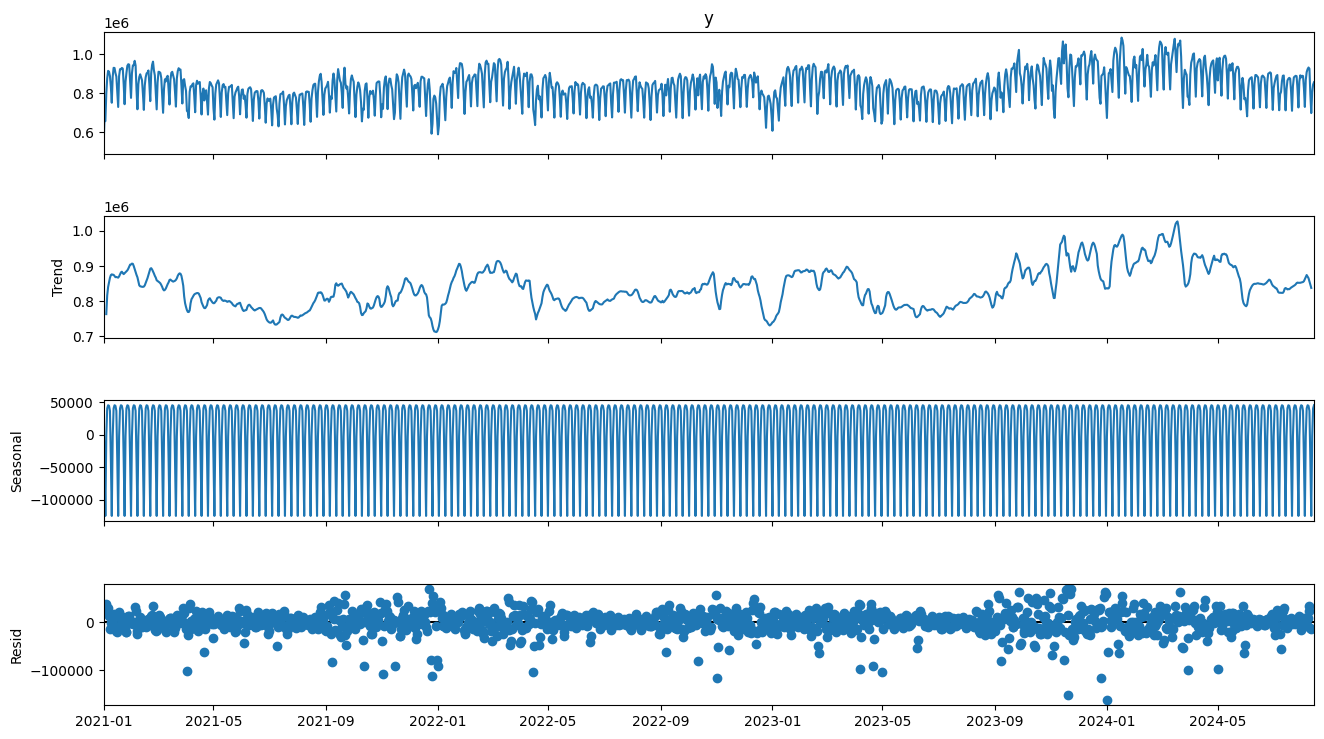

In [62]:
add_decomp = seasonal_decompose(
    data.set_index('ds')["y"],
    model = "additive",
    # period=30
)

fig = add_decomp.plot()
fig.set_size_inches(15, 8)

<Axes: xlabel='resid', ylabel='Density'>

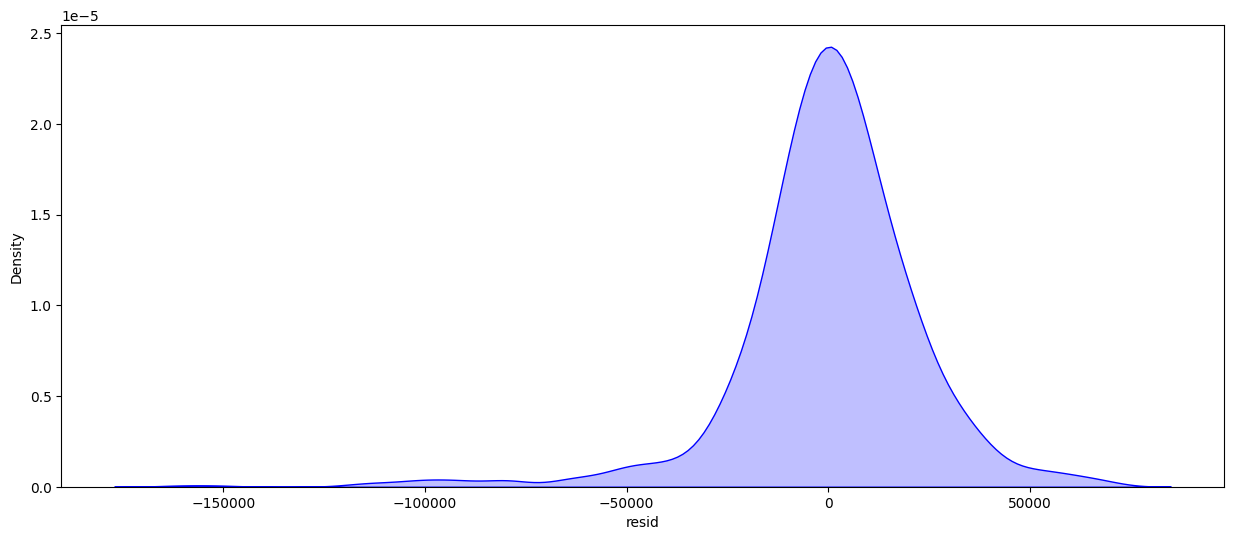

In [63]:
plt.figure(figsize=(15, 6))
sns.kdeplot(add_decomp.resid, color="blue", label="Residuals", fill=True)

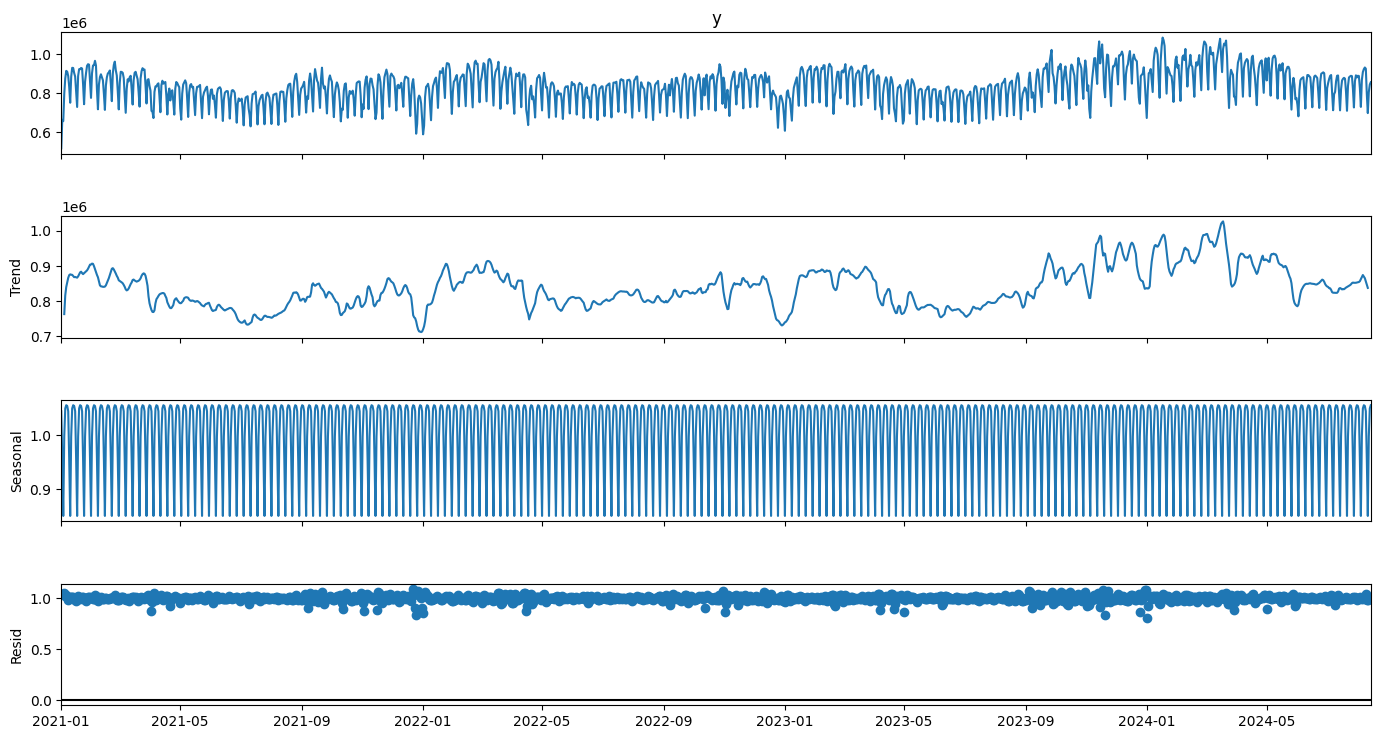

In [64]:
mul_decomp = seasonal_decompose(
    data.set_index('ds')["y"],
    model = "multiplicative",
    # period=30
)

fig = mul_decomp.plot()
fig.set_size_inches(15, 8)

<Axes: xlabel='resid', ylabel='Density'>

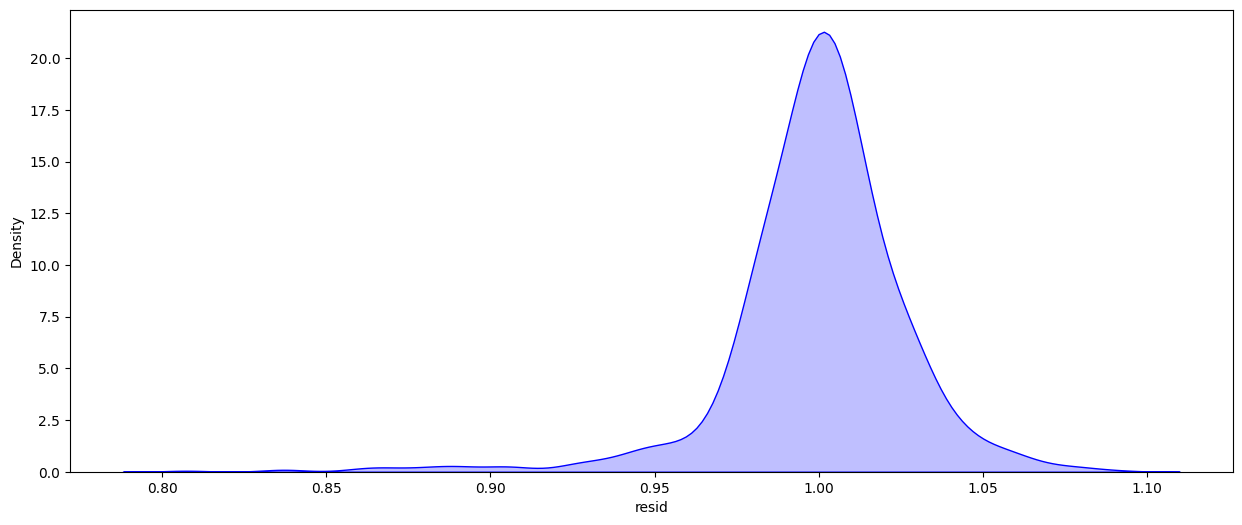

In [65]:
plt.figure(figsize=(15, 6))
sns.kdeplot(mul_decomp.resid, color="blue", label="Residuals", fill=True)

## Validation

In [66]:
data.plot(x='ds', y='y', title='Carga verificada em SP')

In [67]:
start_date = "2021-02-01"
split_date_oot = "2024-06-15"

data['unique_id'] = 0

df_train = data[(data["ds"] >= start_date) & (data["ds"] < split_date_oot)]
df_oot = data[data["ds"] >= split_date_oot]

# print statistics (percentage of data in each set)
print("Train: ", len(df_train) / len(data))
print("Out-of-time: ", len(df_oot) / len(data))

Train:  0.9304084720121029
Out-of-time:  0.046142208774583963


In [68]:
df_oot

,ds,y,unique_id
1261,2024-06-15,816371.131,0
1262,2024-06-16,727934.964,0
1263,2024-06-17,851129.980,0
1264,2024-06-18,886222.722,0
1265,2024-06-19,890934.761,0
...,...,...,...
1317,2024-08-10,795148.516,0
1318,2024-08-11,698073.595,0
1319,2024-08-12,805498.244,0
1320,2024-08-13,844564.077,0


In [69]:
plot_series(
    df_train,
    pd.concat([
        df_oot.rename(columns={'y': 'y_oot'})
        ]),
    models=['y_oot'],
    plot_random=False,
    engine='plotly',
    palette='viridis'
    )

# Feature Engineering

In [70]:
models = [CatBoostRegressor(random_state=0, n_estimators=100),
          LGBMRegressor(random_state=0, n_estimators=100)]

In [71]:
from numba import njit

@njit
def diff(x, lag):
    x2 = np.full_like(x, np.nan)
    for i in range(lag, len(x)):
        x2[i] = x[i] - x[i-lag]
    return x2

In [72]:
model = MLForecast(
    models=models,
    freq='D',
    lags=[
        1,
        7,
        14,
        28
        ],
    lag_transforms={
        1: [
            (rolling_mean, 3),
            (rolling_mean, 7),
            (rolling_mean, 15),
            (rolling_mean, 28),
            (rolling_mean, 60),
            (rolling_mean, 90),
            (diff, 1),
            (diff, 7),
            (diff, 15)
         ],
    },
    date_features=[
        'month',
        'day',
        'week',
        'dayofyear',
        'quarter'
    ],
    num_threads=12
)

model

MLForecast(models=[CatBoostRegressor, LGBMRegressor], freq=D, lag_features=['lag1', 'lag7', 'lag14', 'lag28', 'rolling_mean_lag1_window_size3', 'rolling_mean_lag1_window_size7', 'rolling_mean_lag1_window_size15', 'rolling_mean_lag1_window_size28', 'rolling_mean_lag1_window_size60', 'rolling_mean_lag1_window_size90', 'diff_lag1_lag1', 'diff_lag1_lag7', 'diff_lag1_lag15'], date_features=['month', 'day', 'week', 'dayofyear', 'quarter'], num_threads=12)

In [73]:
prep = model.preprocess(df_train, static_features=[])
prep

,ds,y,unique_id,lag1,lag7,lag14,lag28,rolling_mean_lag1_window_size3,rolling_mean_lag1_window_size7,rolling_mean_lag1_window_size15,rolling_mean_lag1_window_size28,rolling_mean_lag1_window_size60,rolling_mean_lag1_window_size90,diff_lag1_lag1,diff_lag1_lag7,diff_lag1_lag15,month,day,week,dayofyear,quarter
121,2021-05-02,664372.4885,0,722042.6320,690351.4730,690914.3335,672642.9005,797812.499000,802490.615000,790619.323067,802229.249768,824590.586192,839578.099078,-109142.4230,-35319.3095,-135698.5640,5,2,17,122,2
122,2021-05-03,797716.1680,0,664372.4885,823661.1930,795637.1035,806822.2755,739200.058500,798779.331500,782515.876967,801933.877911,820507.978650,836929.616533,-57670.1435,-25978.9845,-121551.6915,5,3,18,123,2
123,2021-05-04,844887.9800,0,797716.1680,857797.5480,824142.5000,835165.1180,728043.762833,795072.899357,789635.999267,801608.659786,818721.917300,835319.793278,133343.6795,-25945.0250,106801.8345,5,4,18,124,2
124,2021-05-05,855127.8475,0,844887.9800,852186.5940,763020.2525,835306.3205,768992.212167,793228.675357,792919.391033,801955.904857,818161.611142,834213.422683,47171.8120,-12909.5680,49250.8765,5,5,18,125,2
125,2021-05-06,866283.8160,0,855127.8475,840209.8100,809677.9080,846166.5170,832577.331833,793648.854429,794985.080867,802663.816536,819202.020033,832972.834511,10239.8675,2941.2535,30985.3475,5,6,18,126,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,2024-06-10,848809.7480,0,721185.1565,813829.9320,835349.6800,923907.7330,805734.178500,836020.076714,806286.807567,851685.564196,884160.945142,901062.115128,-92375.3315,39626.4845,-97064.3875,6,10,24,162,2
1257,2024-06-11,893524.2170,0,848809.7480,866658.6065,878998.7770,948159.0850,794518.464167,841017.193286,815139.383833,849003.493304,882044.735025,899554.607211,127624.5915,34979.8160,132788.6440,6,11,24,163,2
1258,2024-06-12,893535.7605,0,893524.2170,875224.4845,843947.4565,916319.5900,821173.040500,844855.137643,819017.686300,847052.248018,880799.402400,898181.928578,44714.4690,26865.6105,58174.5370,6,12,24,164,2
1259,2024-06-13,887138.6385,0,893535.7605,879224.9785,769262.0010,927692.1830,878623.241833,847471.034214,819986.818533,846238.539821,880890.641408,896425.143717,11.5435,18311.2760,14536.9835,6,13,24,165,2


In [74]:
# fit the models
model.fit(
    df_train,
    id_col='unique_id',
    time_col='ds',
    target_col='y',
    max_horizon=60,
    static_features=[],
    prediction_intervals=PredictionIntervals(n_windows=10, h=60, method="conformal_distribution"),
    fitted=True
)


Learning rate set to 0.241489
0:	learn: 62215.0681800	total: 824us	remaining: 81.6ms
1:	learn: 53966.5496792	total: 1.42ms	remaining: 69.7ms
2:	learn: 47565.0704487	total: 1.93ms	remaining: 62.3ms
3:	learn: 42739.3138448	total: 2.4ms	remaining: 57.6ms
4:	learn: 38799.3357415	total: 3.02ms	remaining: 57.5ms
5:	learn: 36315.4877475	total: 3.63ms	remaining: 56.9ms
6:	learn: 33816.6105602	total: 4.32ms	remaining: 57.4ms
7:	learn: 31584.6523295	total: 4.91ms	remaining: 56.4ms
8:	learn: 30072.5362074	total: 5.38ms	remaining: 54.4ms
9:	learn: 28830.1345920	total: 5.87ms	remaining: 52.9ms
10:	learn: 27600.9139832	total: 6.34ms	remaining: 51.3ms
11:	learn: 26664.1053502	total: 7.1ms	remaining: 52.1ms
12:	learn: 25743.7184119	total: 7.72ms	remaining: 51.7ms
13:	learn: 25182.2521237	total: 8.29ms	remaining: 50.9ms
14:	learn: 24531.5862932	total: 8.81ms	remaining: 49.9ms
15:	learn: 24119.7524588	total: 9.33ms	remaining: 49ms
16:	learn: 23567.2407336	total: 10.1ms	remaining: 49.2ms
17:	learn: 23229

MLForecast(models=[CatBoostRegressor, LGBMRegressor], freq=D, lag_features=['lag1', 'lag7', 'lag14', 'lag28', 'rolling_mean_lag1_window_size3', 'rolling_mean_lag1_window_size7', 'rolling_mean_lag1_window_size15', 'rolling_mean_lag1_window_size28', 'rolling_mean_lag1_window_size60', 'rolling_mean_lag1_window_size90', 'diff_lag1_lag1', 'diff_lag1_lag7', 'diff_lag1_lag15'], date_features=['month', 'day', 'week', 'dayofyear', 'quarter'], num_threads=12)

In [75]:
levels = [80]
forecast_df = model.predict(h=60, level=levels)
forecast_df.head()

,unique_id,ds,CatBoostRegressor,LGBMRegressor,CatBoostRegressor-lo-80,CatBoostRegressor-hi-80,LGBMRegressor-lo-80,LGBMRegressor-hi-80
0,0,2024-06-15,822347.999561,846631.142793,730582.895947,914113.103175,791077.788582,902184.497005
1,0,2024-06-16,782267.766012,768704.138814,723071.340779,841464.191245,723258.727256,814149.550372
2,0,2024-06-17,870630.909948,869299.718896,803531.630228,937730.189667,810620.199121,927979.238671
3,0,2024-06-18,901055.987129,901169.286180,806588.559093,995523.415165,807669.924388,994668.647973
4,0,2024-06-19,889069.676126,862673.110513,811612.384292,966526.967961,754130.419669,971215.801356


In [77]:
fig = plot_series(
    data.tail(80),
    forecast_df,
    level=levels,
    engine='plotly',
    palette='tab10'
    )
fig.update_layout(height=400, width=1500)
fig

In [1]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def evaluate_model(model, df_oot):
    forecast = model.predict(df_oot, return_pred_int=True)
    mae = mean_absolute_error(df_oot['y'], forecast['yhat'])
    rmse = mean_squared_error(df_oot['y'], forecast['yhat'], squared=False)
    r2 = r2_score(df_oot['y'], forecast['yhat'])
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2: {r2:.2f}")
    return forecast

result = evaluate_model(model, df_oot)

NameError: name 'model' is not defined

In [456]:
from statsmodels.stats.diagnostic import normal_ad
from scipy import stats

result = model.forecast_fitted_values()

sw_result = stats.shapiro(result["CatBoostRegressor"])
ad_result = normal_ad(np.array(result["CatBoostRegressor"]), axis=0)
dag_result = stats.normaltest(result["CatBoostRegressor"], axis=0, nan_policy='propagate')


/home/pedro/my_project_dir/energy_demand/.venv/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 66630.



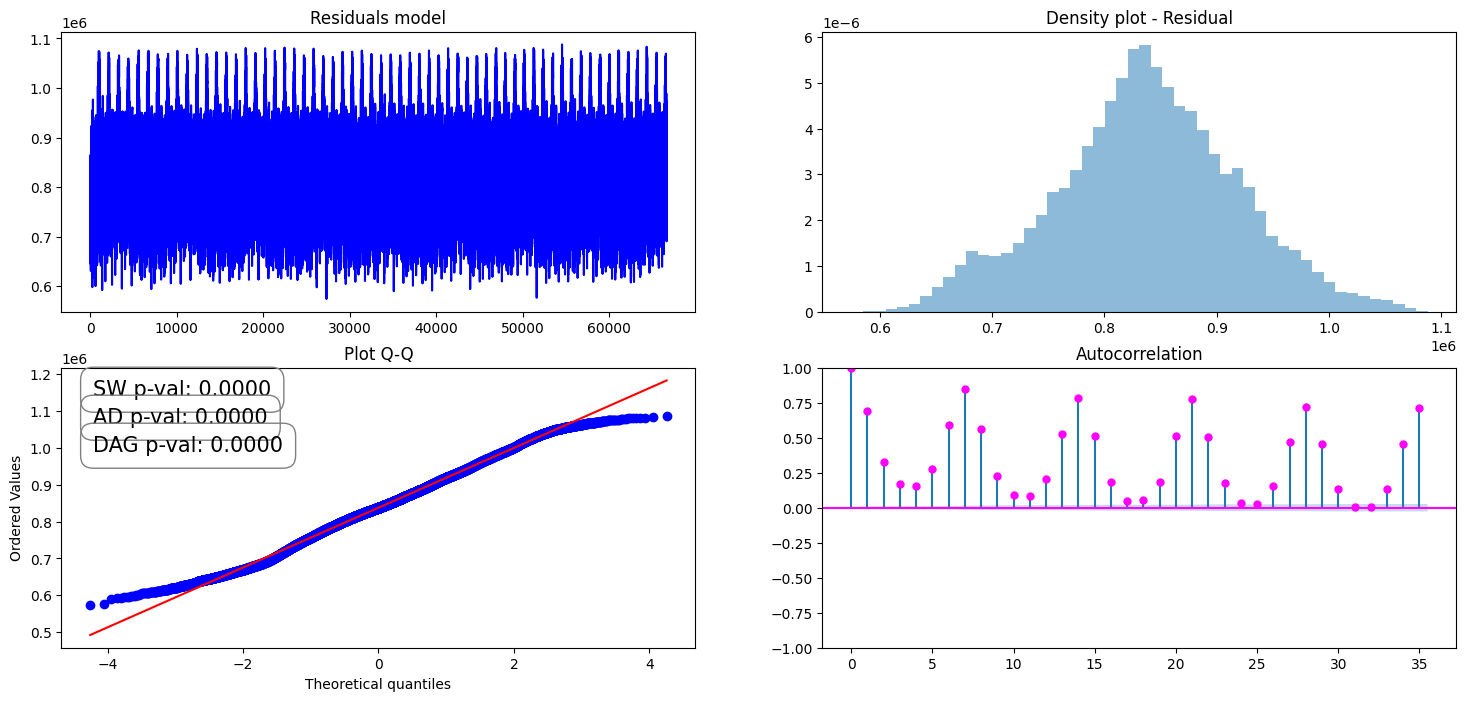

In [457]:
fig, axs = plt.subplots(figsize=(18,8), nrows=2, ncols=2)

# plot[1,1]
axs[0,0].plot(result["CatBoostRegressor"], label="True", color="blue")
axs[0,0].set_title("Residuals model");

# plot
axs[0,1].hist(result["CatBoostRegressor"], density=True,bins=50, alpha=0.5 )
axs[0,1].set_title("Density plot - Residual");

# plot
stats.probplot(result["CatBoostRegressor"], dist="norm", plot=axs[1,0])
axs[1,0].set_title('Plot Q-Q')
axs[1,0].annotate("SW p-val: {:.4f}".format(sw_result[1]), xy=(0.05,0.9), xycoords='axes fraction', fontsize=15,
            bbox=dict(boxstyle="round", fc="none", ec="gray", pad=0.6))

axs[1,0].annotate("AD p-val: {:.4f}".format(ad_result[1]), xy=(0.05,0.8), xycoords='axes fraction', fontsize=15,
            bbox=dict(boxstyle="round", fc="none", ec="gray", pad=0.6))

axs[1,0].annotate("DAG p-val: {:.4f}".format(dag_result[1]), xy=(0.05,0.7), xycoords='axes fraction', fontsize=15,
            bbox=dict(boxstyle="round", fc="none", ec="gray", pad=0.6))
# plot
plot_acf(result["CatBoostRegressor"],  lags=35, ax=axs[1,1],color="fuchsia")
axs[1,1].set_title("Autocorrelation");

plt.show()

In [460]:
import numpy as np
import pandas as pd
from numba import njit
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from mlforecast import MLForecast
from mlforecast.utils import PredictionIntervals
from statsmodels.tsa.seasonal import seasonal_decompose
from optuna import create_study
from optuna.samplers import TPESampler

@njit
def diff(x, lag):
    x2 = np.full_like(x, np.nan)
    for i in range(lag, len(x)):
        x2[i] = x[i] - x[i-lag]
    return x2

@njit
def rolling_mean(x, window):
    x2 = np.full_like(x, np.nan)
    for i in range(window - 1, len(x)):
        x2[i] = np.mean(x[i-window+1:i+1])
    return x2

@njit
def rolling_std(x, window):
    x2 = np.full_like(x, np.nan)
    for i in range(window - 1, len(x)):
        x2[i] = np.std(x[i-window+1:i+1])
    return x2

def seasonal_decomposition_features(df):
    result = seasonal_decompose(df.set_index('ds')['y'], model='additive')
    df['trend'] = result.trend
    df['seasonality'] = result.seasonal
    df['residual'] = result.resid
    return df

def objective(trial):
    catboost_params = {
        'iterations': trial.suggest_int('catboost_iterations', 50, 300),
        'learning_rate': trial.suggest_loguniform('catboost_learning_rate', 1e-3, 0.1),
        'depth': trial.suggest_int('catboost_depth', 4, 10),
    }

    lgbm_params = {
        'n_estimators': trial.suggest_int('lgbm_n_estimators', 50, 300),
        'learning_rate': trial.suggest_loguniform('lgbm_learning_rate', 1e-3, 0.1),
        'num_leaves': trial.suggest_int('lgbm_num_leaves', 20, 100),
    }

    xgb_params = {
        'n_estimators': trial.suggest_int('xgb_n_estimators', 50, 300),
        'learning_rate': trial.suggest_loguniform('xgb_learning_rate', 1e-3, 0.1),
        'max_depth': trial.suggest_int('xgb_max_depth', 3, 10),
    }

    rf_params = {
        'n_estimators': trial.suggest_int('rf_n_estimators', 50, 300),
        'max_depth': trial.suggest_int('rf_max_depth', 3, 20),
    }

    models = [
        CatBoostRegressor(random_state=0, **catboost_params),
        LGBMRegressor(random_state=0, **lgbm_params),
        XGBRegressor(random_state=0, **xgb_params),
        RandomForestRegressor(random_state=0, **rf_params)
    ]

    model = MLForecast(
        models=models,
        freq='D',
        lags=[1, 7, 14, 28, 30, 60, 90],
        lag_transforms={
            1: [
                (rolling_mean, 3),
                (rolling_mean, 7),
                (rolling_mean, 15),
                (rolling_mean, 28),
                (rolling_mean, 60),
                (rolling_mean, 90),
                (rolling_std, 7),
                (rolling_std, 28),
                (diff, 1),
                (diff, 7),
                (diff, 28)
            ],
        },
        date_features=[
            'month',
            'day',
            'week',
            'dayofyear',
            'quarter',
            'dayofweek',
        ],
        num_threads=12
    )

    tscv = TimeSeriesSplit(n_splits=5)
    mae_scores = []

    for train_index, val_index in tscv.split(df_train):
        train = df_train.iloc[train_index]
        val = df_train.iloc[val_index]

        model.fit(
            train,
            id_col='unique_id',
            time_col='ds',
            target_col='y',
            static_features=[],
            max_horizon=60,
            fitted=True
        )

        forecast = model.predict(h=60)
        mae = mean_absolute_error(val['y'], forecast['y'])
        mae_scores.append(mae)

    return np.mean(mae_scores)

# Assuming df_train, holidays, and weather_data are defined
df_train = seasonal_decomposition_features(df_train)

study = create_study(direction='minimize', sampler=TPESampler())
study.optimize(objective, n_trials=50)

best_params = study.best_params

# Use the best parameters to create the final model
final_models = [
    CatBoostRegressor(random_state=0, iterations=best_params['catboost_iterations'],
                      learning_rate=best_params['catboost_learning_rate'],
                      depth=best_params['catboost_depth']),
    LGBMRegressor(random_state=0, n_estimators=best_params['lgbm_n_estimators'],
                  learning_rate=best_params['lgbm_learning_rate'],
                  num_leaves=best_params['lgbm_num_leaves']),
    XGBRegressor(random_state=0, n_estimators=best_params['xgb_n_estimators'],
                 learning_rate=best_params['xgb_learning_rate'],
                 max_depth=best_params['xgb_max_depth']),
    RandomForestRegressor(random_state=0, n_estimators=best_params['rf_n_estimators'],
                          max_depth=best_params['rf_max_depth'])
]

final_model = MLForecast(
    models=final_models,
    freq='D',
    lags=[1, 7, 14, 28, 30, 60, 90],
    lag_transforms={
        1: [
            (rolling_mean, 3),
            (rolling_mean, 7),
            (rolling_mean, 15),
            (rolling_mean, 28),
            (rolling_mean, 60),
            (rolling_mean, 90),
            (rolling_std, 7),
            (rolling_std, 28),
            (diff, 1),
            (diff, 7),
            (diff, 28)
        ],
    },
    date_features=[
        'month',
        'day',
        'week',
        'dayofyear',
        'quarter',
        'dayofweek',
    ],
    num_threads=12
)

final_model.fit(
    df_train,
    id_col='unique_id',
    time_col='ds',
    target_col='y',
    max_horizon=60,
    prediction_intervals=PredictionIntervals(n_windows=3, h=60, method="conformal_distribution"),
    fitted=True
)

levels = [80, 95]
forecast_df = final_model.predict(h=60, level=levels)

# Evaluate the model
y_true = df_oot['y']
y_pred = forecast_df['y']

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

metrics = {
    'MAE': mae,
    'RMSE': rmse,
    'R2': r2,
    'MAPE': mape
}

print("Model Performance Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

/tmp/ipykernel_723363/546091364.py:42: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_723363/546091364.py:43: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_723363/546091364.py:44: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

[I 2024-08-15

0:	learn: 58730.7146153	total: 990us	remaining: 209ms
1:	learn: 58646.1909830	total: 2.31ms	remaining: 243ms
2:	learn: 58590.3472566	total: 3.22ms	remaining: 224ms
3:	learn: 58531.3430604	total: 4.3ms	remaining: 223ms
4:	learn: 58458.3507675	total: 5.22ms	remaining: 216ms
5:	learn: 58391.7027695	total: 6.39ms	remaining: 219ms
6:	learn: 58304.8581789	total: 6.58ms	remaining: 193ms
7:	learn: 58221.5363396	total: 6.93ms	remaining: 177ms
8:	learn: 58142.6240704	total: 7.96ms	remaining: 180ms
9:	learn: 58062.1530237	total: 8.94ms	remaining: 181ms
10:	learn: 57981.8866632	total: 10.3ms	remaining: 188ms
11:	learn: 57900.0319240	total: 10.6ms	remaining: 177ms
12:	learn: 57832.8764758	total: 11.4ms	remaining: 175ms
13:	learn: 57747.1674798	total: 12ms	remaining: 170ms
14:	learn: 57679.6107665	total: 13.7ms	remaining: 179ms
15:	learn: 57611.1491702	total: 14.6ms	remaining: 179ms
16:	learn: 57546.2731508	total: 15.7ms	remaining: 180ms
17:	learn: 57468.6906256	total: 16.9ms	remaining: 182ms
18:	le

[W 2024-08-15 18:31:14,674] Trial 0 failed with parameters: {'catboost_iterations': 212, 'catboost_learning_rate': 0.0025470932534109444, 'catboost_depth': 8, 'lgbm_n_estimators': 113, 'lgbm_learning_rate': 0.007981261602449434, 'lgbm_num_leaves': 85, 'xgb_n_estimators': 159, 'xgb_learning_rate': 0.010497923577314562, 'xgb_max_depth': 10, 'rf_n_estimators': 274, 'rf_max_depth': 8} because of the following error: KeyError("['trend', 'seasonality', 'residual'] not in index").
Traceback (most recent call last):
  File "/home/pedro/my_project_dir/energy_demand/.venv/lib/python3.10/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_723363/546091364.py", line 125, in objective
    forecast = model.predict(h=60)
  File "/home/pedro/my_project_dir/energy_demand/.venv/lib/python3.10/site-packages/mlforecast/forecast.py", line 710, in predict
    forecasts = ts.predict(
  File "/home/pedro/my_project_dir/energy_demand/.venv/

KeyError: "['trend', 'seasonality', 'residual'] not in index"

In [21]:
abfs = AzureBlobFileSystem(
    account_name = ACC_NAME,
    account_key = ACC_KEY,
    container_name = CONTAINER_NAME
    )

path = f"abfs://{CONTAINER_NAME}/{FOLDER}/predictions/predictions_20240815.parquet"

pqdata = ds.dataset(path, filesystem=abfs)
pqdata.schema

ds: timestamp[ns]
y: double
unique_id: int64
CatBoostRegressor: double
LGBMRegressor: double
XGBRegressor: double
RandomForestRegressor: double
CatBoostRegressor-lo-100: double
CatBoostRegressor-lo-90: double
CatBoostRegressor-lo-80: double
CatBoostRegressor-lo-70: double
CatBoostRegressor-lo-60: double
CatBoostRegressor-lo-50: double
CatBoostRegressor-lo-40: double
CatBoostRegressor-lo-30: double
CatBoostRegressor-lo-20: double
CatBoostRegressor-lo-10: double
CatBoostRegressor-hi-10: double
CatBoostRegressor-hi-20: double
CatBoostRegressor-hi-30: double
CatBoostRegressor-hi-40: double
CatBoostRegressor-hi-50: double
CatBoostRegressor-hi-60: double
CatBoostRegressor-hi-70: double
CatBoostRegressor-hi-80: double
CatBoostRegressor-hi-90: double
CatBoostRegressor-hi-100: double
LGBMRegressor-lo-100: double
LGBMRegressor-lo-90: double
LGBMRegressor-lo-80: double
LGBMRegressor-lo-70: double
LGBMRegressor-lo-60: double
LGBMRegressor-lo-50: double
LGBMRegressor-lo-40: double
LGBMRegressor-lo-

In [23]:
(
        pqdata
        .to_table()
        .to_pandas()
        .reset_index(drop=True)
        .assign(
            ds=lambda x: pd.to_datetime(x["ds"]),
        )
    )

,ds,y,unique_id,CatBoostRegressor,LGBMRegressor,XGBRegressor,RandomForestRegressor,CatBoostRegressor-lo-100,CatBoostRegressor-lo-90,CatBoostRegressor-lo-80,CatBoostRegressor-lo-70,CatBoostRegressor-lo-60,CatBoostRegressor-lo-50,CatBoostRegressor-lo-40,CatBoostRegressor-lo-30,CatBoostRegressor-lo-20,CatBoostRegressor-lo-10,CatBoostRegressor-hi-10,CatBoostRegressor-hi-20,CatBoostRegressor-hi-30,CatBoostRegressor-hi-40,CatBoostRegressor-hi-50,CatBoostRegressor-hi-60,CatBoostRegressor-hi-70,CatBoostRegressor-hi-80,CatBoostRegressor-hi-90,CatBoostRegressor-hi-100,LGBMRegressor-lo-100,LGBMRegressor-lo-90,LGBMRegressor-lo-80,LGBMRegressor-lo-70,LGBMRegressor-lo-60,LGBMRegressor-lo-50,LGBMRegressor-lo-40,LGBMRegressor-lo-30,LGBMRegressor-lo-20,LGBMRegressor-lo-10,LGBMRegressor-hi-10,LGBMRegressor-hi-20,LGBMRegressor-hi-30,LGBMRegressor-hi-40,LGBMRegressor-hi-50,LGBMRegressor-hi-60,LGBMRegressor-hi-70,LGBMRegressor-hi-80,LGBMRegressor-hi-90,LGBMRegressor-hi-100,XGBRegressor-lo-100,XGBRegressor-lo-90,XGBRegressor-lo-80,XGBRegressor-lo-70,XGBRegressor-lo-60,XGBRegressor-lo-50,XGBRegressor-lo-40,XGBRegressor-lo-30,XGBRegressor-lo-20,XGBRegressor-lo-10,XGBRegressor-hi-10,XGBRegressor-hi-20,XGBRegressor-hi-30,XGBRegressor-hi-40,XGBRegressor-hi-50,XGBRegressor-hi-60,XGBRegressor-hi-70,XGBRegressor-hi-80,XGBRegressor-hi-90,XGBRegressor-hi-100,RandomForestRegressor-lo-100,RandomForestRegressor-lo-90,RandomForestRegressor-lo-80,RandomForestRegressor-lo-70,RandomForestRegressor-lo-60,RandomForestRegressor-lo-50,RandomForestRegressor-lo-40,RandomForestRegressor-lo-30,RandomForestRegressor-lo-20,RandomForestRegressor-lo-10,RandomForestRegressor-hi-10,RandomForestRegressor-hi-20,RandomForestRegressor-hi-30,RandomForestRegressor-hi-40,RandomForestRegressor-hi-50,RandomForestRegressor-hi-60,RandomForestRegressor-hi-70,RandomForestRegressor-hi-80,RandomForestRegressor-hi-90,RandomForestRegressor-hi-100
0,2024-06-15,816371.131,0,794347.678541,809034.898454,876252.9375,852534.561705,674395.021488,686688.013574,698981.005659,711273.997745,723566.989831,724131.046159,724695.102487,725259.158815,725823.215144,760085.446842,828609.910240,862872.141938,863436.198267,864000.254595,864564.310923,865128.367251,877421.359337,889714.351423,902007.343508,914300.335594,767582.147701,768121.220199,768660.292697,769199.365195,769738.437693,777612.892477,785487.347260,793361.802044,801236.256827,805135.577641,812934.219268,816833.540082,824707.994865,832582.449649,840456.904432,848331.359216,848870.431714,849409.504212,849948.576710,8.504876e+05,847835.1065,848120.531875,848405.95725,848691.382625,848976.8080,850966.050125,852955.29225,854944.534375,856933.7765,866593.35700,885912.51800,895572.0985,897561.340625,899550.58275,9.015398e+05,9.035291e+05,9.038145e+05,9.040999e+05,9.043853e+05,9.046708e+05,798462.594630,806910.025675,815357.456721,823804.887767,832252.318812,836896.767641,841541.216470,846185.665300,850830.114129,851682.337917,853386.785493,8.542390e+05,8.588835e+05,8.635279e+05,8.681724e+05,8.728168e+05,8.812642e+05,8.897117e+05,8.981591e+05,9.066065e+05
1,2024-06-16,727934.964,0,736944.396759,872731.800268,875533.8750,859517.233025,619965.514475,621745.524094,623525.533713,625305.543331,627085.552950,645049.179176,663012.805403,680976.431629,698940.057855,717942.227307,755946.566211,774948.735663,792912.361889,810875.988115,828839.614342,846803.240568,848583.250187,850363.259805,852143.269424,853923.279043,828895.424182,829766.086267,830636.748351,831507.410436,832378.072521,833451.767366,834525.462211,835599.157056,836672.851901,854702.326084,890761.274451,908790.748635,909864.443480,910938.138325,912011.833169,913085.528014,913956.190099,914826.852184,915697.514269,9.165682e+05,835470.9495,840900.033750,846329.11800,851758.202250,857187.2865,859693.521375,862199.75625,864705.991125,867212.2260,871373.05050,879694.69950,883855.5240,886361.758875,888867.99375,8.913742e+05,8.938805e+05,8.993095e+05,9.047386e+05,9.101677e+05,9.155968e+05,823787.881225,8296

In [1]:
from utils import load_predictions

df = load_predictions()
df.info()

2024-08-15 23:21:28.846 | INFO     | utils:load_predictions:309 - Loading predictions


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 87 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   ds                            61 non-null     datetime64[ns]
 1   y                             61 non-null     float64       
 2   unique_id                     61 non-null     int64         
 3   CatBoostRegressor             60 non-null     float64       
 4   LGBMRegressor                 60 non-null     float64       
 5   XGBRegressor                  60 non-null     float64       
 6   RandomForestRegressor         60 non-null     float64       
 7   CatBoostRegressor-lo-100      60 non-null     float64       
 8   CatBoostRegressor-lo-90       60 non-null     float64       
 9   CatBoostRegressor-lo-80       60 non-null     float64       
 10  CatBoostRegressor-lo-70       60 non-null     float64       
 11  CatBoostRegressor-lo-60       60 n